# Scalar Field Theory Monte Carlo Simulations

Faris Sbahi

# Project 1

In this project, we will study a $d$ dimensional scalar field theory on the lattice.

Define the lattice action

$$
S^l_E = \sum_x \{ \frac{1}{2} \chi_x^2 - \frac{\kappa}{2} \sum_{\mu} \chi_x \chi_{x + \hat{\mu}} + g \chi_x^4 \}
$$

$$
\kappa^{-1} := 2d + \alpha \\
\alpha := (m_0a)^2
$$

where $m_0$ is the bare lattice mass term and $a$ is the lattice spacing.

First, fix $g=0$. We wish to compute 

$$
\sigma = \frac{1}{L^d}\sum_x \langle \chi^2_x \rangle
$$

By definition,

$$
\langle \phi(x) \phi(y)\rangle = \frac{1}{Z} \int [d \phi] e^{-S_E(\phi)} \phi(x) \phi(y)
$$

where 


$$
Z = \int [d\phi] e^{-S_E(\phi)}
$$

Hence,

$$
\langle \chi^2_x \rangle = \frac{1}{Z}\int [d \phi] e^{-S_E(\phi)} \chi^2_x
$$

and we can construct $S$ as a matrix-vector product in terms of $M$

$$
S_E^l = \frac{1}{2}\chi_{i}M_{ij}\chi_{j}\\
M_{ij} = - \kappa \sum_{\mu} (\delta_{i + \mu, j} + \delta_{i - \mu, j}) + \delta_{ij}
$$


> Note: it takes too long to build it up in $d=4$ so an alternative is recognize that $g=0$, $\kappa$ nonzero is an NN coupling and Fourier transform to momentum space. There the coupling will be eliminated so you should be able to do a couple of integrals.

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer

from numba import njit

In [28]:
@njit(parallel=True)
def m_ij(i, j, L, d, kappa, g):
    if i == j:
        return 1
    
    for axis in range(d):
        if ((i + L**axis) % (L ** d) == j) or ((i - L**axis) % (L ** d) == j):
            return -1 * kappa
        
    return 0

@njit(parallel=True)
def M_inv(L, d, kappa, g):
    M = np.zeros((L ** d, L ** d))
    
    for i in range(L**d):
        for j in range(L ** d):
            M[i, j] = m_ij(i, j, L, d, kappa, g)
            
    return np.linalg.inv(M)

# 1. $L = 16, g = 0, \alpha = 0.25$

In [30]:
@njit(parallel=True)
def compute_exact_observables(G, L, d):
    sigma = np.trace(G) / (L ** d)
    
    chi = np.sum(G) / (L ** d)
    
    
    F_mat = np.array(
            [ G[i,j] * np.cos(2 * np.pi * (
                (i % L) - (j % L)
                ) / L
                ) for i in range(L**d) for j in range(L**d)]
        )
    
    F = np.sum(F_mat) / (L**d)
    
    M_L = 2 * (np.sin(np.pi / L)) / (np.sqrt((chi / F) - 1)) # desire chi/F = 1.61
    
    return sigma, chi, F, M_L    

In [31]:
g = 0
L = 2 ** 4

alpha = 0.25

for d in [2, 3]:
    start = timer()
    
    print("d: ", d)
    
    kappa = 1 / ( 2 * d + alpha)
    
    G = M_inv(L, d, kappa, g)
    
    sigma, chi, F, M_L = compute_exact_observables(G, L, d)
    
    dt = timer() - start
    
    print("sigma: ", sigma, "chi: ", chi, "F: ", F, "M_L: ", M_L)
    print("time: ", dt)

d:  2
sigma:  1.6020690583803094 chi:  16.999999999999808 F:  10.565806785026737 M_L:  0.5000000000000061
time:  2.0157172460003494
d:  3
sigma:  1.319788680629584 chi:  24.99999999999466 F:  15.537951154455978 M_L:  0.5000000000003478
time:  6.822154597999543


# $L = 16, g = 0.1, \alpha = 0.25, \kappa = 0$

In [6]:
g = 0.1
L = 2 ** 4

alpha = 0.25

for d in range(2, 5):
    print("d: ", d)
    
    kappa = 1 / ( 2 * d + alpha)
    
    G = M_inv(L, d, kappa, g)
    
    sigma = np.trace(G) / (L ** d)
    
    chi = np.sum(G) / (L ** d)
    
    F = np.sum(
    [ G[i,j] * np.cos(2 * np.pi * (
        (i % L) - (j % L)
        ) / L
        ) for i in range(L**d) for j in range(L**d)]) / (L**d)
    
    M_L = 2 * (np.sin(np.pi / L)) / (np.sqrt((chi / F) - 1)) # desire chi/F = 1.61
    
    print("sigma: ", sigma, "chi: ", chi, "F: ", F, "M_L: ", M_L)

d:  2


TypeError: too many arguments: expected 3, got 4

$$
\langle \phi(x) \phi(y)\rangle =  \int [d \phi] P([\phi]) \phi(x) \phi(y)
$$

for 

$$
P([\phi]) = \frac{e^{-S_E^l(\phi)}}{Z}
$$

to simplify take configuration

$$
\zeta := [\phi]
$$

and

$$
W(\zeta) = e^{-S_E^l(\phi)} 
$$

so that

$$
P(\zeta) = \frac{W(\zeta)}{\sum_{\zeta} W(\zeta)}
$$

Now, write

$$
\chi_x \equiv \rho_x s_x
$$

with $s_x = sgn(\chi_x)$. And so

$$
S_E^l(x) = \sum_x \{ \frac{1}{2} \rho_x^2 - \frac{\kappa}{2} \sum_{\mu} \rho_x \rho_{x + \hat{\mu}}s_x s_{x + \hat{\mu}} + g \rho_x^4 \}
$$

For the spin update $\rho$ is fixed so that

$$
W(\zeta) = \exp(-\sum_{\mu} \rho_x \rho_{x + \hat{\mu}}s_x s_{x + \hat{\mu}})
$$

and so the spin update for $T$ has the following algorithm:

1. Keep two lists: sites_visited, sites_visited_flag

2. Initialize: pick site at random
    - add to sites_visited
    - mark as visited with flag
    
3. Go over all visited sites and look over all neighboring directions. Let the visted site have spin $s_1$ and its neighbor $s_2$:
    - if $s_1 \neq s_2$ do nothing
    - if $s_1 = s_2$ then with probability $1-\exp(-2 \kappa \rho_x \rho_y)$

4. Repeat for all site in sites_visited

5. When all sites of sites_visisted have been exhausted, then flip the signs of all on sites_visited_flag

Now, for the regular update let us define a constant (recalling that we update one site at a time)

$$
\alpha := \kappa \sum_{x, \hat{\mu}} (\chi_{x + \hat{\mu}} + \chi_{x - \hat{\mu}})
$$

and hence, up to a constant,

$$
W(\zeta) = \exp(-\frac{1}{2} (\chi_x - \alpha)^2 - g \chi_x^4)
$$



In [2]:
@njit
def get_neighbors(idx, L, d):
    n = np.array([(idx + direction * (L ** dim)) % (L ** d) for direction in [-1, 1] for dim in range(d)])
    return n

@njit # TODO - parallel
def spin_update(lattice_rad, lattice_signs, L, d, kappa):
    sites_visited = []
    sites_visited_flag = set()

    init = np.random.randint(0, high = L ** d - 1)

    sites_visited.append(init)
    sites_visited_flag.add(init)

    while (len(sites_visited) != 0 and len(sites_visited_flag) != L ** d):
        idx = sites_visited.pop()
        for nbr_idx in get_neighbors(idx, L, d):
            #print("checking spin for time dim: ", idx % L, nbr_idx % L)
            #print("sites visited: ", sites_visited_flag, lattice_signs[nbr_idx], lattice_signs[idx])
            #print(nbr_idx not in sites_visited_flag and lattice_signs[nbr_idx] == lattice_signs[idx])
            if nbr_idx not in sites_visited_flag and lattice_signs[nbr_idx] == lattice_signs[idx]:
                #print(nbr_idx)
                
                prob = 1 - np.exp(- 2 * kappa * lattice_rad[idx] * lattice_rad[nbr_idx])
                s = np.random.random()
                #print(s, prob)
                if s <= prob:
                    #print("added time dim: ", idx % L, nbr_idx % L)
                    sites_visited.append(nbr_idx)
                    sites_visited_flag.add(nbr_idx)

    return init, np.array(list(sites_visited_flag))

@njit
def update_spin_at_sites(lattice_signs, sites):
    lattice_signs[sites] = -1 * lattice_signs[sites]

@njit
def regular_update(lattice_rad, lattice_signs, g, L, d, kappa):
    for idx in range(L ** d):
        gauss = np.random.randn()
        
        nbrs = get_neighbors(idx, L, d)
        alpha = kappa * np.dot(lattice_rad[nbrs], lattice_signs[nbrs])
        
        new_chi = alpha + gauss
        
        s = np.random.uniform(b=1.0, a=0.0)
        prob = np.exp(-g * (new_chi ** 4 - lattice_rad[idx] ** 4))
        
        if g == 0 or s <= prob: 
            lattice_rad[idx] = np.abs(new_chi)
            lattice_signs[idx] = np.sign(new_chi)

In [3]:
@njit
def compute_sigma(lattice_rad, L, d):
    return np.sum(lattice_rad ** 2) / (L ** d)

@njit
def compute_chi(x, lattice_rad, L, d, sites):
    rho_x = lattice_rad[x]
    return np.sum(rho_x * lattice_rad[sites])

@njit
def compute_F(x, lattice_rad, L, d, sites):        
    rho_x = lattice_rad[x]
            
    return np.sum(
        np.array(
    [ rho_x * lattice_rad[idx] * np.cos(2 * np.pi * (
        (x % L) - (idx % L)
        ) / L
        ) for idx in sites]))
    

# 2. $L = 16, g = 0, \alpha = 0.25$

In [4]:
@njit
def run_monte_carlo(L, g, alpha, N, d, kappa):
    sigmas = []
    sigma = 0

    chis = []
    chi = 0

    Fs = []
    F = 0

    lattice_signs = np.ones(L ** d)
    lattice_rad = np.random.uniform(b=1.0, a=0.0, size=int(L**d))

    for i in range(N):
        x, sites = spin_update(lattice_rad, lattice_signs, L, d, kappa)

        chi_i = compute_chi(x, lattice_rad, L, d, sites)
        chi += chi_i / N
        chis.append(chi_i)

        F_i = compute_F(x, lattice_rad, L, d, sites)
        F += F_i / N
        Fs.append(F_i)

        update_spin_at_sites(lattice_signs, sites)
        regular_update(lattice_rad, lattice_signs, g, L, d, kappa)

        sigma_i = compute_sigma(lattice_rad, L, d)
        sigma += sigma_i / N
        sigmas.append(sigma_i)

    return sigma, chi, F, sigmas, chis, Fs
        

In [6]:
N = 5000
alpha = 0.25
L = 16
g = 0.

all_sigmas = []
all_chis = []
all_Fs = []

for d in [2, 3, 4]: #[2, 3, 4]:
    print("d: ", d)
    print("g: ", g)

    start = timer()

    kappa = 1 / ( 2 * d + alpha)

    sigma, chi, F, sigmas, chis, Fs = run_monte_carlo(L, g, alpha, N, d, kappa)

    M_L = 2 * (np.sin(np.pi / L)) / (np.sqrt((chi / F) - 1))

    print("Sigma: ", sigma)
    print("Chi: ", chi)
    print("F ", F)
    print("M(L): ", M_L)

    dt = timer() - start
    print("time: ", dt)

    all_sigmas.append(sigmas)
    all_chis.append(chis)
    all_Fs.append(Fs)

d:  2
g:  0.0
Sigma:  1.604497860389095
Chi:  16.457546917659062
F  10.332522488647509
M(L):  0.5067747735409128
time:  1.5147039060011593
d:  3
g:  0.0
Sigma:  1.3205066381085293
Chi:  25.561766232359076
F  16.20858823504985
M(L):  0.5136398569296189
time:  23.276657398999305
d:  4
g:  0.0
Sigma:  1.1995986294257432
Chi:  42.295160589957945
F  20.628317935046645
M(L):  0.38071484792764343
time:  384.68111969500023


# $L = 16, g = 0.1, \alpha = 0.25, \kappa = 0$

In [ ]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1
        
    block = int(round(bar_length * progress))
    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [27]:
N = 5000
alpha = 0.25
L = 16
g = 0.1

all_sigmas = []
all_chis = []
all_Fs = []

for d in [2, 3, 4]: #[2, 3, 4]:
    print("d: ", d)
    print("g: ", g)

    start = timer()

    kappa = 0.

    sigma, chi, F, sigmas, chis, Fs = run_monte_carlo(L, g, alpha, N, d, kappa)

    print("Sigma: ", sigma)
    print("Chi: ", chi)
    print("F ", F)

    dt = timer() - start
    print("time: ", dt)

    all_sigmas.append(sigmas)
    all_chis.append(chis)
    all_Fs.append(Fs)

d:  2
g:  0.1
Sigma:  0.6152293889181316
Chi:  0.6136666530828708
F  0.6136666530828708
time:  1.4380702239996026
d:  3
g:  0.1
Sigma:  0.615452048934876
Chi:  0.6158887660359952
F  0.6158887660359952
time:  22.840403767999305
d:  4
g:  0.1
Sigma:  0.615538142436201
Chi:  0.6139618506782782
F  0.6139618506782782
time:  379.00182876799954


# 3. $L=8, g=0.1, \alpha = -1.5$

In [26]:
N = 5000
alpha = -1.5
L = 8
g = 0.1

all_sigmas = []
all_chis = []
all_Fs = []

for d in [2, 3, 4]: #[2, 3, 4]:
    print("d: ", d)
    print("g: ", g)

    start = timer()

    kappa = 1 / ( 2 * d + alpha)

    sigma, chi, F, sigmas, chis, Fs = run_monte_carlo(L, g, alpha, N, d, kappa)

    M_L = 2 * (np.sin(np.pi / L)) / (np.sqrt((chi / F) - 1))

    print("Sigma: ", sigma)
    print("Chi: ", chi)
    print("F ", F)
    print("M(L): ", M_L)

    dt = timer() - start
    print("time: ", dt)
    print("\n")

    all_sigmas.append(sigmas)
    all_chis.append(chis)
    all_Fs.append(Fs)

d:  2
g:  0.1
Sigma:  0.826503498236686
Chi:  5.983268831454501
F  2.39506188950748
M(L):  0.6253012334293515
time:  0.355082059999404
d:  3
g:  0.1
Sigma:  0.6865782824757546
Chi:  2.9045560279530744
F  2.0967941012601923
M(L):  1.233121471136136
time:  3.1431476500001736
d:  4
g:  0.1
Sigma:  0.655868184528913
Chi:  2.3450104558026448
F  1.9602701316574191
M(L):  1.7276022632192052
time:  24.178033447000416


# Project 2

In the symmetric phase one can argue that

$$
\langle \phi(x) \phi(x') \rangle = \int d^dp \frac{Z}{p^2 + M^2_{phys}}(1+O(p^2)) e^{i p \cdot (x-x')}
$$

where $Z$ is the residue of the propagator (a constant).



In [7]:
N = 10000
alpha = -0.5
d = 2
g = 0.01

all_sigmas = []
all_chis = []
all_Fs = []

for L in [24, 32, 48]:
    print("d: ", d)
    print("g: ", g)
    print("L: ", L)
    print("alpha": alpha)

    start = timer()

    kappa = 1 / ( 2 * d + alpha)

    sigma, chi, F, sigmas, chis, Fs = run_monte_carlo(L, g, alpha, N, d, kappa)

    M_L = 2 * (np.sin(np.pi / L)) / (np.sqrt((chi / F) - 1))

    print("Sigma: ", sigma)
    print("Chi: ", chi)
    print("F ", F)
    print("M(L): ", M_L)

    dt = timer() - start
    print("time: ", dt)
    print("\n")

    all_sigmas.append(sigmas)
    all_chis.append(chis)
    all_Fs.append(Fs)

d:  2
g:  0.01
L:  24
Sigma:  1.6448625249373459
Chi:  41.76214307839195
F  23.07044113251372
M(L):  0.29002216497510924
time:  3.3303832949986827
d:  2
g:  0.01
L:  32
Sigma:  1.6532602669192482
Chi:  46.22675786749943
F  31.502899545191912
M(L):  0.28674540858232905
time:  5.8116651689997525
d:  2
g:  0.01
L:  48
Sigma:  1.6540742644711302
Chi:  43.15427499620436
F  35.70219397200293
M(L):  0.2863104449674739
time:  12.120570416000191


## 3. Renormalization

In [10]:
N = 10000
d = 2
L = 48
g = 0.01

M_Ls = []
alphas = [-0.55, -0.56, -0.57, -0.58, -0.59, -0.60, -0.61]

for alpha in alphas:
    print("d: ", d)
    print("g: ", g)
    print("L: ", L)
    print("alpha: ", alpha)

    start = timer()

    kappa = 1 / ( 2 * d + alpha)

    sigma, chi, F, sigmas, chis, Fs = run_monte_carlo(L, g, alpha, N, d, kappa)

    M_L = 2 * (np.sin(np.pi / L)) / (np.sqrt((chi / F) - 1))

    print("Sigma: ", sigma)
    print("Chi: ", chi)
    print("F ", F)
    print("M(L): ", M_L)

    dt = timer() - start
    print("time: ", dt)
    print("\n")

    M_Ls.append(M_L)
    
print("M(L)s: ", M_Ls)

d:  2
g:  0.01
L:  48
alpha:  -0.55
Sigma:  1.7758303027252416
Chi:  80.85599710691297
F  57.53925765326405
M(L):  0.20548339889301354
time:  12.196395140001187
d:  2
g:  0.01
L:  48
alpha:  -0.56
Sigma:  1.7999977430517375
Chi:  94.2143892797887
F  65.21677976157274
M(L):  0.19616751928234286
time:  12.22783830499975
d:  2
g:  0.01
L:  48
alpha:  -0.57
Sigma:  1.8581697659070138
Chi:  119.67863509794228
F  71.94382613525222
M(L):  0.16058600515339422
time:  12.252749231000053
d:  2
g:  0.01
L:  48
alpha:  -0.58
Sigma:  1.8872515218976271
Chi:  141.2824126023787
F  79.48810148838898
M(L):  0.1483560760943546
time:  12.29970921399945
d:  2
g:  0.01
L:  48
alpha:  -0.59
Sigma:  1.935146503077796
Chi:  160.82927934466716
F  89.31247858219626
M(L):  0.14617750844526078
time:  12.341755383999043
d:  2
g:  0.01
L:  48
alpha:  -0.6
Sigma:  1.9948713242122347
Chi:  223.50655103800688
F  99.00426689926846
M(L):  0.1166451860062983
time:  12.451491570998769
d:  2
g:  0.01
L:  48
alpha:  -0.61
Si

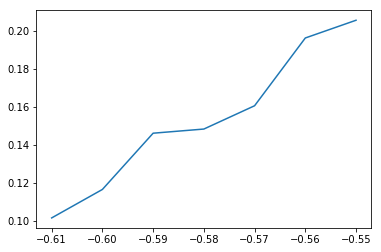

f_0:  1.7314680641097149 alpha_c:  -0.6687036803504697


In [29]:
#alphas = [-0.55, -0.56, -0.57, -0.58, -0.59, -0.60, -0.61]
#M_Ls = [0.20548339889301354, 0.19616751928234286, 0.16058600515339422, 
#     0.1483560760943546, 0.14617750844526078, 0.1166451860062983, 0.10169743399618077]

plt.figure()

plt.plot(
    alphas, 
    M_Ls
        )
plt.show()

z = np.polyfit(alphas, M_Ls, 1)
f_0 = z[0]
alpha_c = -1 * z[1] / z[0]
print("f_0: ", f_0, "alpha_c: ", alpha_c)

In [11]:
N = 5000
d = 3
L = 48
g = 0.01

M_Ls = []
alphas = [-0.68, -0.69, -0.70, -0.71, -0.72]

for alpha in alphas:
    print("d: ", d)
    print("g: ", g)
    print("L: ", L)
    print("alpha: ", alpha)

    start = timer()

    kappa = 1 / ( 2 * d + alpha)

    sigma, chi, F, sigmas, chis, Fs = run_monte_carlo(L, g, alpha, N, d, kappa)

    M_L = 2 * (np.sin(np.pi / L)) / (np.sqrt((chi / F) - 1))

    print("Sigma: ", sigma)
    print("Chi: ", chi)
    print("F ", F)
    print("M(L): ", M_L)

    dt = timer() - start
    print("time: ", dt)
    print("\n")

    M_Ls.append(M_L)
    
print("M(L)s: ", M_Ls)

d:  3
g:  0.01
L:  48
alpha:  -0.68
Sigma:  1.2544055782582062
Chi:  152.072098223931
F  100.74999803859458
M(L):  0.18327314671120448
time:  628.0092589370015
d:  3
g:  0.01
L:  48
alpha:  -0.69
Sigma:  1.2621838152003961
Chi:  204.02509510836123
F  105.94760555933205
M(L):  0.13595319741429776
time:  628.6254015969989
d:  3
g:  0.01
L:  48
alpha:  -0.7
Sigma:  1.2712098191367238
Chi:  329.00671103256616
F  131.9864427583643
M(L):  0.10706258680357736
time:  628.0723397859983
d:  3
g:  0.01
L:  48
alpha:  -0.71
Sigma:  1.279717706684487
Chi:  378.9087179906591
F  169.62761618178956
M(L):  0.11776379601094264
time:  627.5318388809992
d:  3
g:  0.01
L:  48
alpha:  -0.72
Sigma:  1.291080661136063
Chi:  691.0670910027103
F  200.08410277107998
M(L):  0.08350290665046634
time:  629.2326551349997


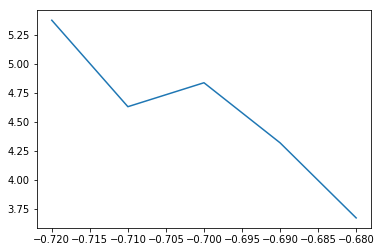

f_0:  310.3039166488896 alpha_c:  -0.5770442287439866


In [28]:
plt.figure()

#alphas = [-0.68, -0.69, -0.70, -0.71, -0.72]
#M_Ls = [0.18327314671120448, 0.13595319741429776, 0.10706258680357736, 0.11776379601094264, 0.08350290665046634]
M_Ls = np.log(M_Ls) / np.log(0.629971)

plt.plot(
    alphas, 
    M_Ls
        )
plt.show()

z = np.polyfit(alphas, M_Ls, 1)
f_0 = np.power(-1 * z[0], 1. / 0.629971) # (-x)^d !
alpha_c = -1 * z[1] / z[0]
print("f_0: ", f_0, "alpha_c: ", alpha_c)

In [18]:
N = 5000
d = 4
L = 12
g = 0.01

M_Ls = []
alphas = [-0.55, -0.6, -0.65, -0.7, -0.75]

for alpha in alphas:
    print("d: ", d)
    print("g: ", g)
    print("L: ", L)
    print("alpha: ", alpha)

    start = timer()

    kappa = 1 / ( 2 * d + alpha)

    sigma, chi, F, sigmas, chis, Fs = run_monte_carlo(L, g, alpha, N, d, kappa)

    M_L = 2 * (np.sin(np.pi / L)) / (np.sqrt((chi / F) - 1))

    print("Sigma: ", sigma)
    print("Chi: ", chi)
    print("F ", F)
    print("M(L): ", M_L)

    dt = timer() - start
    print("time: ", dt)
    print("\n")

    M_Ls.append(M_L)

print("M(L)s: ", M_Ls)

d:  4
g:  0.01
L:  12
alpha:  -0.55
Sigma:  1.063967158425264
Chi:  25.918732638003465
F  13.146697913752242
M(L):  0.5251755788791591
time:  118.80397330800042


d:  4
g:  0.01
L:  12
alpha:  -0.6
Sigma:  1.0684835322487527
Chi:  27.527883445257892
F  13.90054626993081
M(L):  0.5228013005335937
time:  118.40928011299911


d:  4
g:  0.01
L:  12
alpha:  -0.65
Sigma:  1.0735407420417393
Chi:  36.986599986619225
F  15.062754889315517
M(L):  0.42906201529167753
time:  118.82759361499848


d:  4
g:  0.01
L:  12
alpha:  -0.7
Sigma:  1.078415732216858
Chi:  42.356580578698754
F  16.480535214276443
M(L):  0.41310735767717677
time:  118.51911265799936


d:  4
g:  0.01
L:  12
alpha:  -0.75
Sigma:  1.0847175421195892
Chi:  63.01823440441564
F  20.004544242449
M(L):  0.3530101605731351
time:  118.41766424899834




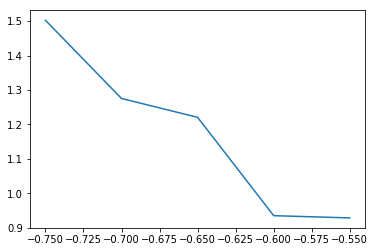

f_0:  8.831906918123329 alpha_c:  -0.2554201624006888


In [26]:
plt.figure()

#alphas = [-0.55, -0.6, -0.65, -0.7, -0.75]
#M_Ls = [0.5251755788791591, 0.5228013005335937, 0.42906201529167753, 0.41310735767717677, 0.3530101605731351]

M_Ls = np.log(M_Ls) / np.log(0.5)

plt.plot(
    alphas, 
    M_Ls
        )
plt.show()

z = np.polyfit(alphas, M_Ls, 1)
f_0 = np.power(z[0], 2)
alpha_c = -1 * z[1] / z[0]
print("f_0: ", f_0, "alpha_c: ", alpha_c)

# 4. Spontaneous Symmetry Breaking

In [25]:
N = 5000
d = 3
g = 0.01
alpha = -0.7

all_chis = []

for L in [16, 24, 32, 48]:
    print("d: ", d)
    print("g: ", g)
    print("L: ", L)
    print("alpha: ", alpha)

    start = timer()

    kappa = 1 / ( 2 * d + alpha)

    sigma, chi, F, sigmas, chis, Fs = run_monte_carlo(L, g, alpha, N, d, kappa)

    print("Sigma: ", sigma)
    print("Chi: ", chi)
    print("F ", F)

    dt = timer() - start
    print("time: ", dt)
    print("\n")

    all_chis.append(chis)

d:  3
g:  0.01
L:  16
alpha:  -0.7
Sigma:  1.2820988929646815
Chi:  204.14253149125554
F  29.224332270229414
time:  23.208888260000094


d:  3
g:  0.01
L:  24
alpha:  -0.7
Sigma:  1.2740922452313739
Chi:  237.4132924253314
F  61.465900713686416
time:  75.67101109800205


d:  3
g:  0.01
L:  32
alpha:  -0.7
Sigma:  1.271672485526377
Chi:  260.89720733719713
F  86.00028608929593
time:  178.36587800100097


d:  3
g:  0.01
L:  48
alpha:  -0.7
Sigma:  1.2702044998682804
Chi:  231.23711869137648
F  126.25598667290309
time:  600.4243153309981




In [30]:
N = 5000
d = 3
g = 0.01
alpha = -0.8

all_chis = []

for L in [16, 24, 32, 48]:
    print("d: ", d)
    print("g: ", g)
    print("L: ", L)
    print("alpha: ", alpha)

    start = timer()

    kappa = 1 / ( 2 * d + alpha)

    sigma, chi, F, sigmas, chis, Fs = run_monte_carlo(L, g, alpha, N, d, kappa)

    print("Sigma: ", sigma)
    print("Chi: ", chi)
    print("F ", F)

    dt = timer() - start
    print("time: ", dt)
    print("\n")

    all_chis.append(chis)

d:  3
g:  0.01
L:  16
alpha:  -0.8
Sigma:  1.8854617957234208
Chi:  3232.2724248503205
F  18.11190015015419
time:  31.10753751700031


d:  3
g:  0.01
L:  24
alpha:  -0.8
Sigma:  1.8747444395856216
Chi:  10489.62276926511
F  28.20206925256676
time:  101.74482436000108


d:  3
g:  0.01
L:  32
alpha:  -0.8
Sigma:  1.8835379130660426
Chi:  24865.013837631705
F  23.61958456042128
time:  242.18655403500088


d:  3
g:  0.01
L:  48
alpha:  -0.8
Sigma:  1.8816615389118032
Chi:  85022.69003774619
F  9.26270167614302
time:  829.3860743310033




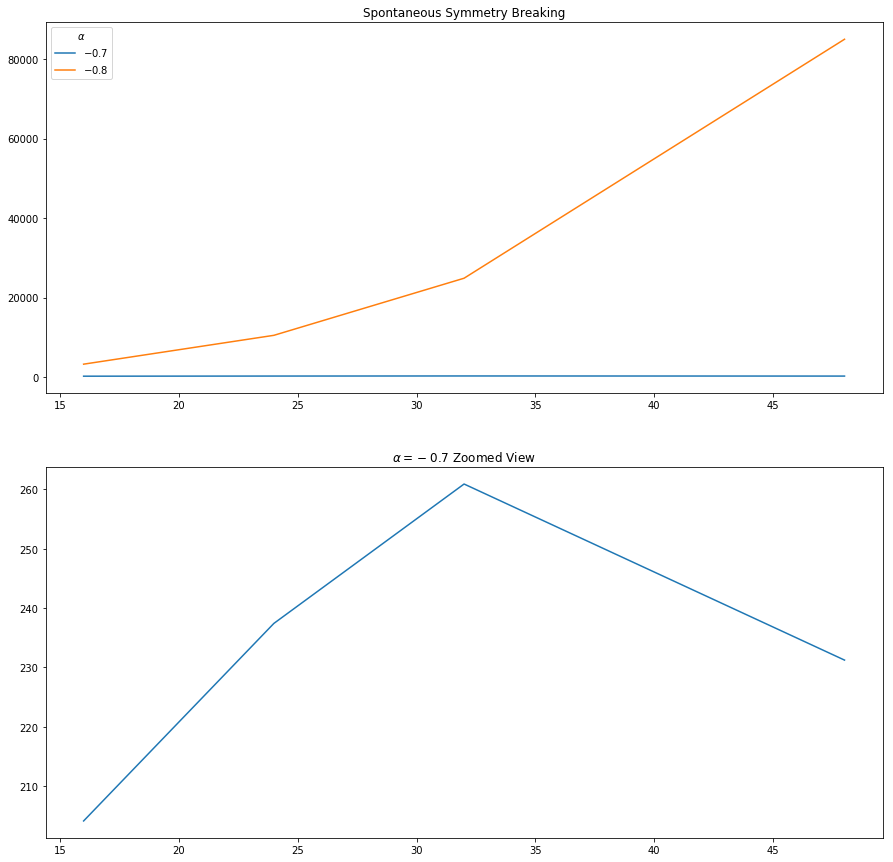

In [64]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

figsize = (20, 20)
plt.figure(figsize = (15, 15))

plt.xlabel("L")
plt.ylabel("Chi")

Ls = [16, 24, 32, 48]
chi1s = [204.14253149125554, 237.4132924253314, 260.89720733719713, 231.23711869137648]
chi2s = [3232.2724248503205, 10489.62276926511, 24865.013837631705, 85022.69003774619]

plt.subplot(2, 1, 1)

plt.title("Spontaneous Symmetry Breaking")
plt.plot(
    Ls, 
    chi1s,
    label=r'$-0.7$'
        )

plt.plot(
    Ls, 
    chi2s,
    label=r'$-0.8$'
        )

plt.legend(title=r'$\alpha$')

plt.subplot(2, 1, 2)
plt.title(r'$\alpha=-0.7$ Zoomed View')
plt.plot(
    Ls, 
    chi1s
)

plt.show()